# Machine Learning Pipeline for ERP-based BCI system
This script has several pipelines for classifying EEG ERP data - with and without hyperparameter search.

### Importing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
from os import path as op
from pathlib import Path
import yaml
from yaml import CLoader as Loader
from glob import glob
import matplotlib.pyplot as plt
import scipy.stats as ss
import json
# MNE
import mne
from mne_bids import write_raw_bids, BIDSPath, update_sidecar_json
from mne_bids.stats import count_events
from mne import io, EvokedArray
from mne.decoding import Vectorizer, get_coef, LinearModel
# Scikit-learn
# from sklearn.utils.fixes import loguniform
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, balanced_accuracy_score, fbeta_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix
    # Classifiers
from sklearn import svm
from sklearn.svm import LinearSVC    
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


mne.set_log_level(verbose='Warning')

### Config & Pathing

In [2]:
## Read Config File
# this shouldn't change if you run this script from its default location in code/import
bids_root = '../..'

config_file = op.join(bids_root, 'config.json')
config = json.load(open(config_file))

study_name = config['Study']['Name']
task_name = config['Study']['TaskName']
data_type = config['EEG']['data_type']
eog = config['EEG']['eog']
baseline = config['Analysis']['baseline']
# fix per changes to config
cl_p = config['Analysis']['Machine Learning']
n_jobs = cl_p['n_jobs']
epochs_suffix = config['EEG']['epochs_suffix']

## Pathing
source_path = op.join(bids_root, 'derivatives', '1_erp_preprocessing')

derivatives_path = op.join(bids_root, 'derivatives', '2_erp_classification')
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)

out_path = op.join(derivatives_path, 'data')
if Path(out_path).exists() == False:
    Path(out_path).mkdir(parents=True)

report_path = op.join(derivatives_path, 'reports')
if Path(report_path).exists() == False:
    Path(report_path).mkdir(parents=True)

fig_path = op.join(derivatives_path, 'figures')
if Path(fig_path).exists() == False:
    Path(fig_path).mkdir(parents=True) 
    
tab_path = op.join(derivatives_path, 'tables')
if Path(tab_path).exists() == False:
    Path(tab_path).mkdir(parents=True) 
    
# output files
out_file = op.join(tab_path, 'classification_concat_results.csv')
test_file = op.join(tab_path, 'classification_pilot_baseline_results.csv.csv')
summary_file =  op.join(tab_path, 'classification_accuracy_summary.csv')
plot_stem = op.join(fig_path, 'plot_')
fig_format = 'pdf'

## Subjects & Loading Them In

In [3]:
prefix = 'sub-'
subjects = sorted([s[-7:] for s in glob(source_path + '/' + prefix + '*')])
print("n subjects = ", len(subjects))


epochs = {}
for subject in subjects:
    subj_path = op.join(source_path, subject, data_type)
    f = op.join(subj_path, subject + '_task-Concatenated' + epochs_suffix)
    print(f)
    epochs[subject] = mne.read_epochs(f,
                                      proj=False,
                                      verbose=None, 
                                      preload=True).apply_baseline([None, 0]) 

../../derivatives/1_erp_preprocessing/sub-ooo/eeg/sub-ooo_task-Concatenated-epo.fif


## No Hyperparameter Search Pipeline
This pipeline runs through a series of different classifiers and saves several evaluation metrics for later analysis.

In [4]:
rng = cl_p['random_state'] # = 42
n_jobs = cl_p['n_jobs'] # = 10

### Instantiating classifiers, parameter grids, and scoring metrics.
scaler = StandardScaler()
vectorizer = Vectorizer()

svm = LinearSVC(C=8, max_iter=10000, verbose=False, random_state=rng, dual='auto')
lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier(random_state=rng, n_jobs=n_jobs)
logreg = LinearModel(LogisticRegression(solver='lbfgs', max_iter=1000, n_jobs=n_jobs, verbose=False, random_state=rng))

# 'log_loss' = logistic regression
lr_sdg = SGDClassifier(loss='log_loss', max_iter=10000, verbose=False, random_state=rng)
# 'hinge' = linear SVM
svm_sgd = SGDClassifier(loss='hinge', max_iter=10000, verbose=False, random_state=rng)

# Dictionary of classifiers to iterate through
classifiers = {'SVM': svm,
               'LDA': lda,
               'RF': rf,
               'LogReg': logreg,
               'LR_SGD': lr_sdg,
               'SVM_SGD': svm_sgd
              }

## SCORING
scoring = {'Prec': make_scorer(precision_score, zero_division=0),
           'Bal_Acc': make_scorer(balanced_accuracy_score),
           'Acc': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'ROC': make_scorer(roc_auc_score),
           'Matthews_Coef': make_scorer(matthews_corrcoef),
           'Fbeta_0.5': make_scorer(fbeta_score, beta = 0.5),
           'Fbeta_1.5': make_scorer(fbeta_score, beta = 1.5),
           'F1_score': make_scorer(f1_score, zero_division=0)
          }

cv = StratifiedKFold(n_splits=10, shuffle=False )#, shuffle=True, random_state=rng)

-------
sub-ooo 
Tasks: ['FlickerFace', 'FlickerSingle', 'Face'] 
-------

-------
FlickerFace
-------
Running classifier: SVM


/tmp/ipykernel_3666859/1483577431.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  D = subj_epochs.get_data() # Copy = True/False?


Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.82      0.57      0.67        54
           1       0.15      0.36      0.21        11

    accuracy                           0.54        65
   macro avg       0.48      0.47      0.44        65
weighted avg       0.70      0.54      0.60        65



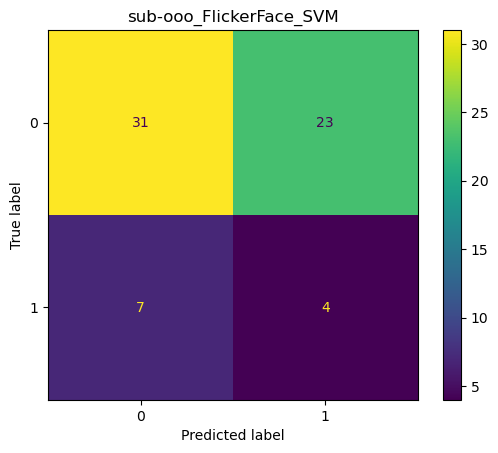

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        54
           1       0.22      0.18      0.20        11

    accuracy                           0.75        65
   macro avg       0.53      0.53      0.53        65
weighted avg       0.73      0.75      0.74        65



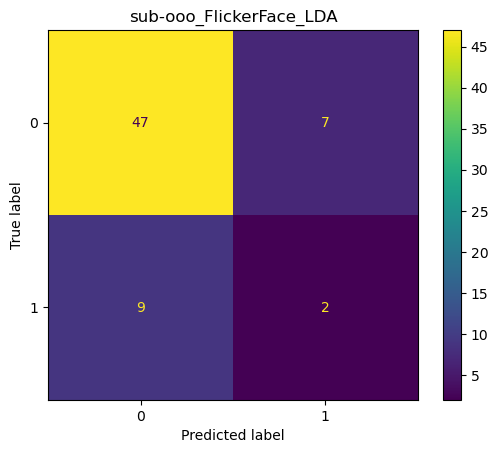

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        54
           1       0.00      0.00      0.00        11

    accuracy                           0.83        65
   macro avg       0.42      0.50      0.45        65
weighted avg       0.69      0.83      0.75        65



/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

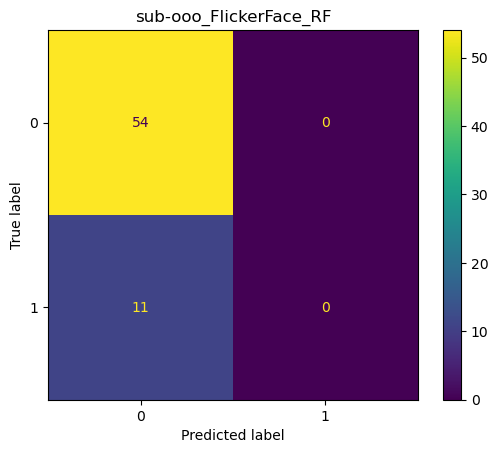

-------
Running classifier: LogReg
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        54
           1       0.25      0.18      0.21        11

    accuracy                           0.77        65
   macro avg       0.55      0.54      0.54        65
weighted avg       0.74      0.77      0.75        65



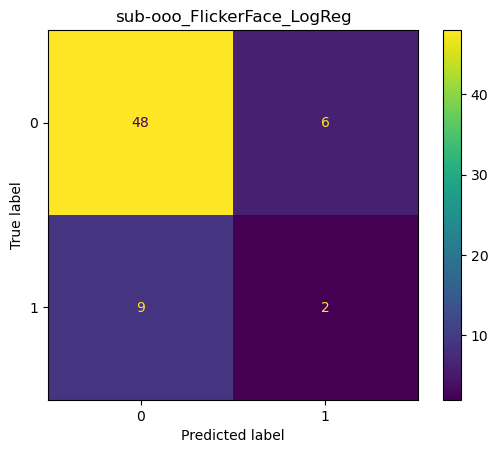

-------
Running classifier: LR_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        54
           1       0.15      0.27      0.19        11

    accuracy                           0.62        65
   macro avg       0.49      0.48      0.47        65
weighted avg       0.71      0.62      0.65        65



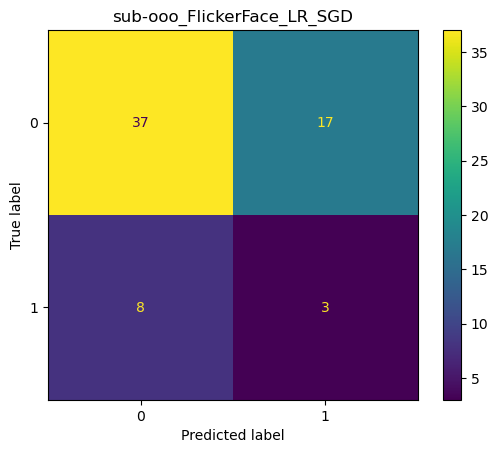

-------
Running classifier: SVM_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        54
           1       0.21      0.27      0.24        11

    accuracy                           0.71        65
   macro avg       0.53      0.53      0.53        65
weighted avg       0.74      0.71      0.72        65



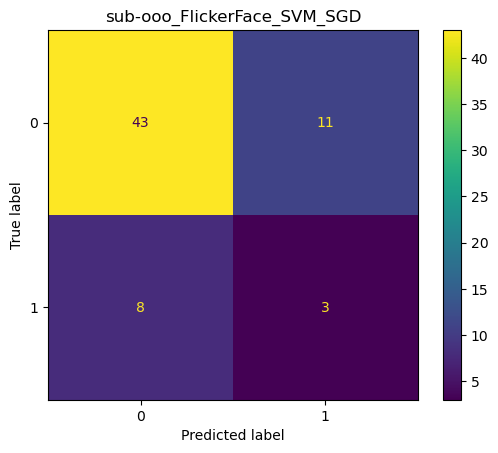


-------
FlickerSingle
-------
Running classifier: SVM


/tmp/ipykernel_3666859/1483577431.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  D = subj_epochs.get_data() # Copy = True/False?


Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.79      0.59      0.67        58
           1       0.08      0.18      0.11        11

    accuracy                           0.52        69
   macro avg       0.43      0.38      0.39        69
weighted avg       0.68      0.52      0.58        69



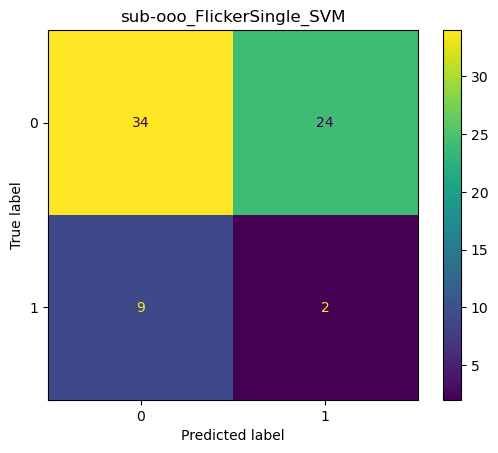

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        58
           1       0.00      0.00      0.00        11

    accuracy                           0.67        69
   macro avg       0.40      0.40      0.40        69
weighted avg       0.68      0.67      0.67        69



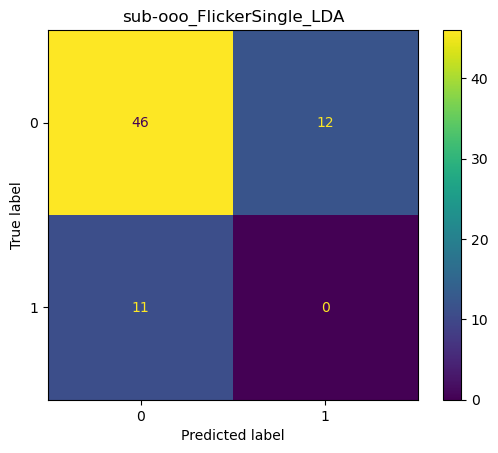

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        58
           1       0.00      0.00      0.00        11

    accuracy                           0.84        69
   macro avg       0.42      0.50      0.46        69
weighted avg       0.71      0.84      0.77        69



/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/brynnh/miniforge3/envs/ncil/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

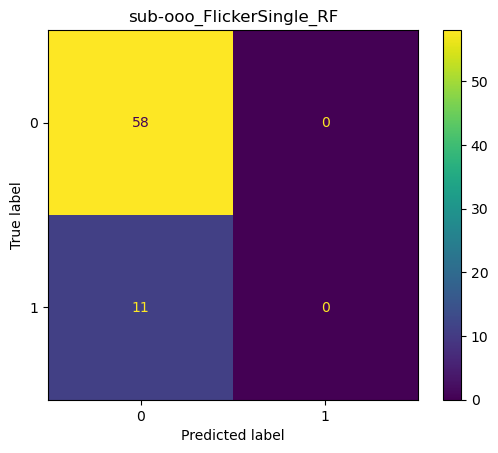

-------
Running classifier: LogReg
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        58
           1       0.00      0.00      0.00        11

    accuracy                           0.72        69
   macro avg       0.41      0.43      0.42        69
weighted avg       0.69      0.72      0.71        69



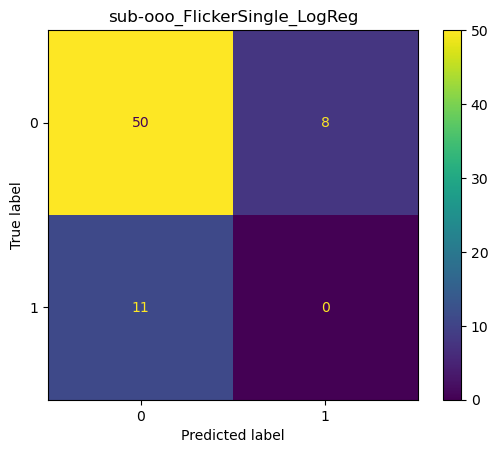

-------
Running classifier: LR_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.80      0.71      0.75        58
           1       0.06      0.09      0.07        11

    accuracy                           0.61        69
   macro avg       0.43      0.40      0.41        69
weighted avg       0.68      0.61      0.64        69



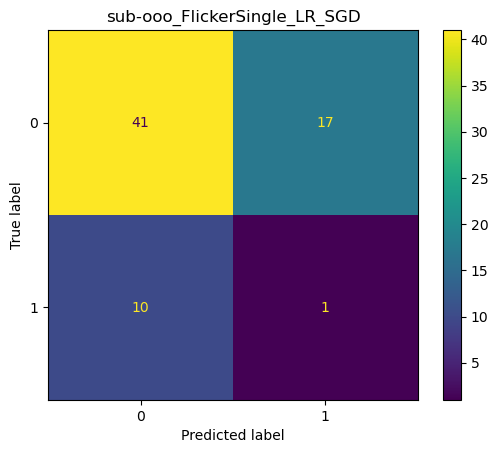

-------
Running classifier: SVM_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        58
           1       0.12      0.18      0.15        11

    accuracy                           0.67        69
   macro avg       0.48      0.47      0.47        69
weighted avg       0.72      0.67      0.69        69



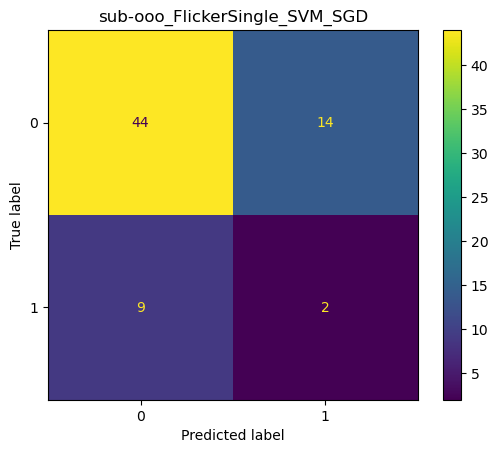


-------
Face
-------
Running classifier: SVM


/tmp/ipykernel_3666859/1483577431.py:25: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  D = subj_epochs.get_data() # Copy = True/False?


Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        50
           1       0.41      0.64      0.50        14

    accuracy                           0.72        64
   macro avg       0.65      0.69      0.65        64
weighted avg       0.78      0.72      0.74        64



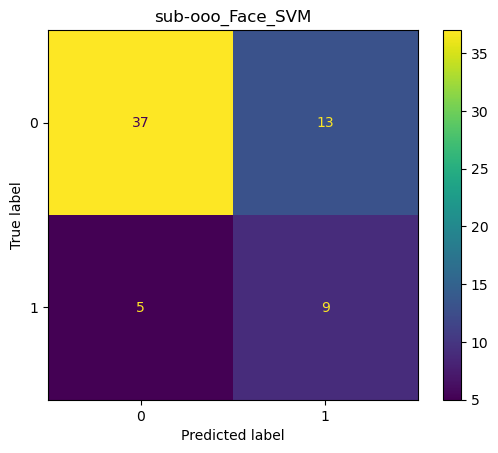

-------
Running classifier: LDA
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.50      0.21      0.30        14

    accuracy                           0.78        64
   macro avg       0.66      0.58      0.59        64
weighted avg       0.74      0.78      0.75        64



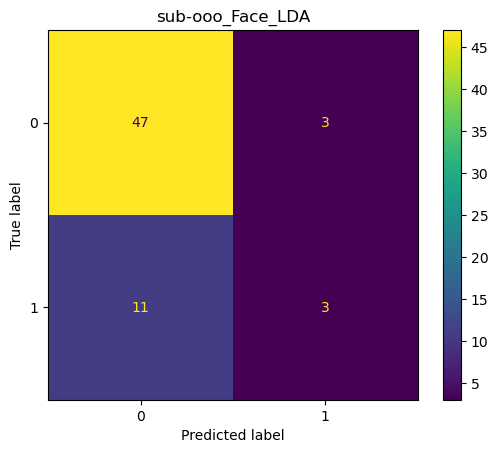

-------
Running classifier: RF
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        50
           1       0.67      0.14      0.24        14

    accuracy                           0.80        64
   macro avg       0.73      0.56      0.56        64
weighted avg       0.77      0.80      0.74        64



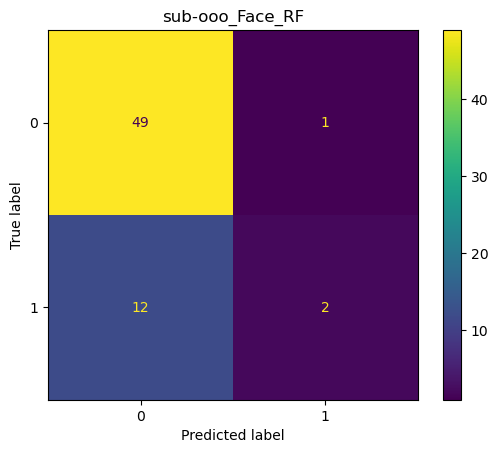

-------
Running classifier: LogReg
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.44      0.29      0.35        14

    accuracy                           0.77        64
   macro avg       0.63      0.59      0.60        64
weighted avg       0.74      0.77      0.75        64



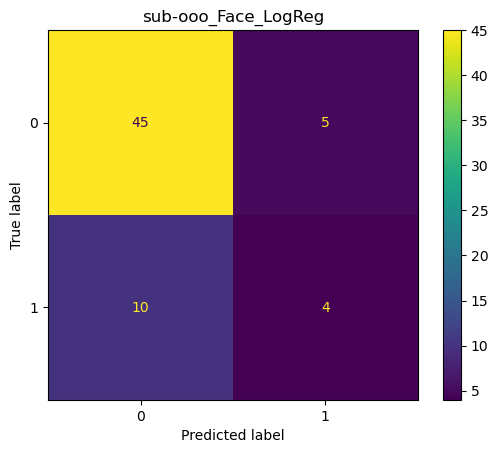

-------
Running classifier: LR_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        50
           1       0.35      0.50      0.41        14

    accuracy                           0.69        64
   macro avg       0.60      0.62      0.60        64
weighted avg       0.73      0.69      0.71        64



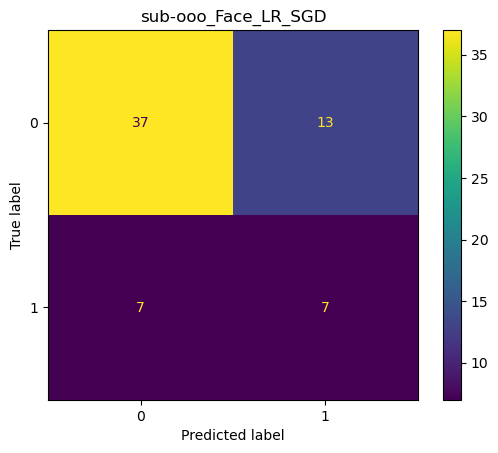

-------
Running classifier: SVM_SGD
Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.47      0.64      0.55        14

    accuracy                           0.77        64
   macro avg       0.68      0.72      0.69        64
weighted avg       0.80      0.77      0.78        64



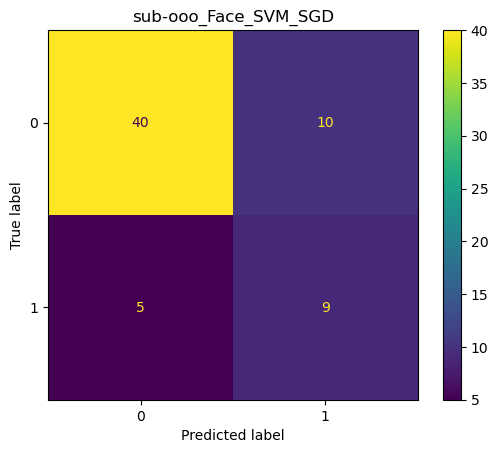

In [5]:
# Making the crossvalidation to be used in the RandomizedSearch
data_table = pd.DataFrame()
data_table_list = []
for subject in subjects:
    # Find all tasks for the subject
    subject_tasks = [task for task in ['FlickerFace', 'FlickerSingle', 'Face'] if task in (key.split('/')[0] for key in epochs[subject].event_id.keys()) ]
    
    print(f'-------\n{subject} \nTasks: {subject_tasks} \n-------' )
 
    for task in subject_tasks:
        
        print('\n-------\n\033[;40m' + task + '\033[m')
                
        subj_epochs = epochs[subject][task]
        
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Condition', 1:'Block', 2:'Status', 3:'Location'} )
        label_map = {'target':1, 'nontarget':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']        
        
        # Can just slice subj_epochs to get events for specific tasks -> i.e., `subj_epochs[task].get_data()`
        D = subj_epochs.get_data() # Copy = True/False?
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(D, 
                                                            labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=rng,
                                                            shuffle=True
                                                           )

        # Classifier Loop
        for c_name, c in classifiers.items():
            print('-------\nRunning classifier: \033[1;91;40m' + c_name + '\033[m')

            # Making the Pipeline
            clf = Pipeline([('Vectorizer', vectorizer),
                             ('Scaler', scaler),
                             (c_name, c)                                 
                             ])

            # Cross validating
            cv_cv = cross_validate(clf, X_train, y_train, 
                                   cv=cv,
                                   scoring=scoring,
                                   return_train_score=True, # Determines if Training scores are included in .cv_results_
                                   n_jobs=5,
                                   error_score='raise' # For debugging purposes
                                   )

            print('Training Classifier')
            clf = clf.fit(X_train, y_train)

            print('Predicting...')
            y_pred = clf.predict(X_test)

            print('Scoring...')        
            print(classification_report(y_test, y_pred))

            # Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
            cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
            cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
            cmd.plot()
            plt.title(subject + '_' + str(task).replace('/', '_') + '_' + c_name)
            plt.show()

            # Saving CV results to a DataFrame 
            results = pd.DataFrame(cv_cv)

            data_table_list.append(pd.DataFrame({'participant_id': subject,
                                              'Condition': task,
                                              'Classifier': c_name,

                                              # Confusion_matrix saved in format: [[TN, FN] [FP, TP]]
                                              'Confusion_Matrix': str(cm),                                                 

                                              'CV_Train_Bal_Accuracy': results['train_Bal_Acc'].round(3) * 100,
                                              'CV_Test_Bal_Accuracy': results['test_Bal_Acc'].round(3) * 100,
                                              'Test_Bal_Accuracy': round(balanced_accuracy_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Accuracy': results['train_Acc'].round(3) * 100,
                                              'CV_Test_Accuracy': results['test_Acc'].round(3) * 100,
                                              'Test_Accuracy': round(accuracy_score(y_test, y_pred), 3) * 100, 

                                              'CV_Train_Precision': results['train_Prec'].round(3) * 100,
                                              'CV_Test_Precision': results['test_Prec'].round(3) * 100,                                                
                                              'Test_Precision': round(precision_score(y_test, y_pred, zero_division=0), 3) * 100,    

                                              'CV_Train_Matthews_coef': results['train_Matthews_Coef'].round(3),
                                              'CV_Test_Matthews_coef': results['test_Matthews_Coef'].round(3),
                                              'Matthews_Coef': round(matthews_corrcoef(y_test, y_pred), 3),

                                              'CV_Train_Recall': results['train_Recall'].round(3) * 100,
                                              'CV_Test_Recall': results['test_Recall'].round(3) * 100,
                                              'Test_recall': round(recall_score(y_test, y_pred), 3) * 100,

                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'CV_Train_Fbeta_0.5': results['train_Fbeta_0.5'].round(3),
                                              'Fbeta_0.5': round(fbeta_score(y_test, y_pred, beta = 0.5, zero_division=0), 3),

                                              'CV_Train_Fbeta_1.5': results['train_Fbeta_1.5'].round(3),
                                              'CV_Test_Fbeta_1.5': results['test_Fbeta_1.5'].round(3),
                                              'Fbeta_1.5': round(fbeta_score(y_test, y_pred, beta = 1.5, zero_division=0), 3),

                                              'CV_Train_F1': results['train_F1_score'].round(3),
                                              'CV_Test_F1': results['test_F1_score'].round(3),
                                              'F1_score': round(f1_score(y_test, y_pred, zero_division=0), 3),

                                              'CV_Train_ROC_AUC': results['train_ROC'].round(3),
                                              'CV_Test_ROC_AUC': results['test_ROC'].round(3),                                             
                                              'Test_ROC_AUC': round(roc_auc_score(y_test, y_pred), 3),

                                              'Mean Fit Time': results['fit_time'].round(3),
                                              'Mean Score Time': results['score_time'].round(3)
                                             }, index=[0]
                                            )
                               )

    # # Saving Data to CSV Per Participant
    # data_table = pd.concat(data_table_list)
    # data_table.to_csv(f'{str(subject)} new_Data.csv')

data_table = pd.concat(data_table_list)
data_table.to_csv('../../derivatives/2_erp_classification/tables/classification_pilot_baseline_results.csv', index=False) #out_file, index=False)

## Data vis & Analysis

In [11]:
acc_tab = pd.read_csv('../../derivatives/2_erp_classification/tables/classification_pilot_baseline_results.csv')

/tmp/ipykernel_3666859/749741676.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(kind='point', join=False,


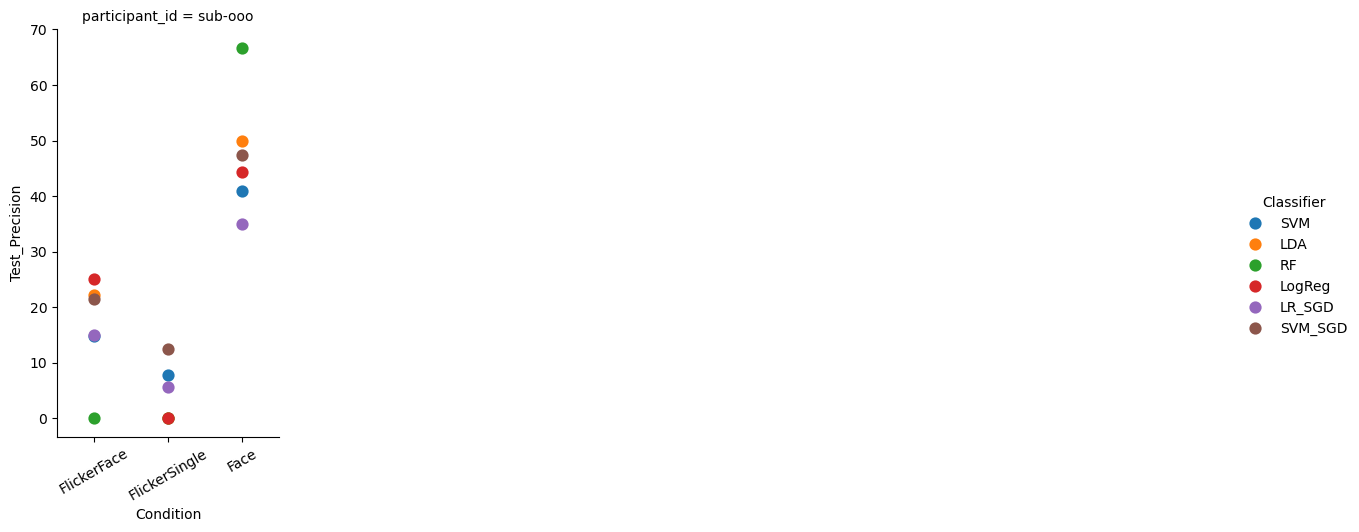

In [9]:
ax = sns.catplot(kind='point', join=False,
                data=acc_tab,
                y='Test_Precision', x='Condition', hue='Classifier', 
                 col='participant_id', col_wrap=5,
                aspect=.5
                )
ax.set_xticklabels(rotation = 30)

## Hyperparameter Search Classification Pipeline
This pipeline runs through a series of different classifiers and uses randomized_search_CV to on several hyperparameters.

### Instantiating classifiers, parameter grids, and scoring metrics.

In [ ]:
scaler = StandardScaler()
vectorizer = Vectorizer()

svm = LinearSVC(random_state=42, max_iter=5000, dual=True)

svm_params = {
    'SVM__C': np.logspace(-4, 3, num=30, dtype=float),
    'SVM__class_weight': ['balanced', None],
    'SVM__tol': np.logspace(-5,1, num=50, dytpe=float)
}

lda = LinearDiscriminantAnalysis(solver='svd')

lda_params = {
    'LDA__n_components': [1, None],
    'LDA__store_covariance': [True, False]
}


rf = RandomForestClassifier(bootstrap = True, max_features='sqrt', random_state=42, n_jobs=10)

rf_max_depth = list(np.arange(5, 100, dtype=int))
rf_max_depth.append(None) 
rf_max_leaf_nodes = list(np.arange(5, 200, dtype=int))
rf_max_leaf_nodes.append(None)

rf_params = {
    'RF__max_depth': rf_max_depth,
    'RF__min_samples_leaf': np.linspace(1, 5, num=5, dtype=int), 
    'RF__min_samples_split': np.linspace(1, 10, num=10, dtype=int), 
    'RF__n_estimators': np.linspace(10, 3000, num=100, dtype=int), 
    'RF__max_samples': np.linspace(0.1, 1.0, num=10, dtype=float), 
    'RF__max_leaf_nodes': rf_max_leaf_nodes,
    'RF__class_weight': ['balanced', 'balanced_subsample', None],
}

classifiers = {'SVM': {svm:svm_params},
               'LDA': {lda:lda_params},
               'RF': {rf:rf_params}
              }

## SCORING
scoring = {'Prec': make_scorer(precision_score, zero_division=0),
           'Bal_Acc': make_scorer(balanced_accuracy_score),
           'Acc': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'ROC': make_scorer(roc_auc_score),
           'Matthews_Coef': make_scorer(matthews_corrcoef),
           'Fbeta_0.5': make_scorer(fbeta_score, beta = 0.5),
           'Fbeta_1.5': make_scorer(fbeta_score, beta = 1.5),
           'F1_score': make_scorer(f1_score, zero_division=0)
          }

## Which scoring metric will RandomizedSearchCV refit for? (Case-sensitive); must be one of the above, or False
refit = False

### Batch Loop

In [ ]:
%%time
%xmode Verbose

# Making the crossvalidation to be used in the RandomizedSearch
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for subject in subjects:
    print('\n-------\n\033[;40m' + subject + '\033[m')
    
    # Clearing out the saved data for each participant
    data_table = pd.DataFrame()
    data_table_list = []
    
    for contr, conds in contrasts.items():
        print(f'-------\n\033[94;40m {contr} \033[m')
        subj_epochs = epochs[subject][conds]
        
        # Create a list of labels from event codes mapped to event_id
        event_id_rev = dict(zip(subj_epochs.event_id.values(), subj_epochs.event_id.keys()))
        labels_all = [event_id_rev[e] for e in subj_epochs.events[:, 2]]
        labels_all = pd.DataFrame(labels_all)[0].str.split('/', expand=True).rename(columns={0:'Colour', 1:'Orientation', 2:'Type', 3:'Status', 4:'Location'} )
        label_map = {'Target':1, 'Standard':0}
        labels_all['labels'] = labels_all['Status'].map(label_map)
        labels = labels_all['labels']
        
        # Extract data from subj_epochs and vectorize 
        D = subj_epochs.get_data()
        
        # Create train-test split
        X_train, X_test, y_train, y_test = train_test_split(D, 
                                                            labels,
                                                            stratify=labels,
                                                            test_size=cl_p['test_size'], 
                                                            random_state=42,
                                                            shuffle=True
                                                           )

        # FUNKY DICTIONARY MAGIC, WHOA!
        for c_name in classifiers.keys():
            for clf, params in classifiers[c_name].items():
                print(f'-------\nRunning classifier: \033[1;91;40m {c_name} \033[m')
                
                # Making the Pipeline for GridSearchCV
                pipe = Pipeline([('Vectorizer', vectorizer),
                                 ('Scaler', scaler),
                                 (c_name, clf)                                 
                                 ])

                # Hyperparemter Tuning with RandomizedSearchCV
                gs = RandomizedSearchCV(pipe,
                                        params,
                                        cv=cv,
                                        scoring=scoring,
                                        refit=refit,
                                        return_train_score=True, # Determines if Training scores are included in .cv_results_
                                        n_jobs=5,
                                        n_iter=20,
                                        error_score='raise' # For debugging purposes
                                        )
                
## Should remove the 'params' in final version - the continuous params make for very large output
                print('Searching and Selecting Optimal Hyperparameters...')
                gs.fit(X_train, y_train)

                print(f'Predicting with Chosen Hyperparameters: {gs.best_params_}')
                y_pred = gs.best_estimator_.predict(X_test)

                print('Scoring...')        
                print(classification_report(y_test, y_pred))
                
                # Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
                cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
                cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
                cmd.plot()
                plt.title(f'{subject} _ {str(contr).replace("/","_")} _ {c_name}')
                plt.show()
                
## Some goofy stuff going on here -> may be due to the refitting strategy of the RandomizedSearch which is set to Precision...?
#                 p, r, c = precision_recall_curve(X_test, y_pred)
#                 prc = PrecisionRecallDisplay(precision=p, recall=r)
#                 prc.plot()
#                 plt.show()

                # Saving CV results to a DataFrame 
                results = pd.DataFrame(gs.cv_results_)
                
                data_table_list.append(pd.DataFrame({'participant_id': subject,
                                                  'Condition': contr,
                                                  'Classifier': c_name,
                                                  'Parameters Used': str(gs.best_params_),
                                                   
                                                  # Confusion_matrix saved in format: [[TN, FN] [FP, TP]]
                                                  'Confusion_Matrix': str(cm),                                                 
                                                  
                                                  'CV_Train_Bal_Accuracy': results['mean_train_Bal_Acc'].round(3) * 100,
                                                  'CV_Test_Bal_Accuracy': results['mean_test_Bal_Acc'].round(3) * 100,
                                                  'Test_Bal_Accuracy': round(balanced_accuracy_score(y_test, y_pred), 3) * 100,
                                                  
                                                  'CV_Train_Accuracy': results['mean_train_Acc'].round(3) * 100,
                                                  'CV_Test_Accuracy': results['mean_test_Acc'].round(3) * 100,
                                                  'Test_Accuracy': round(accuracy_score(y_test, y_pred), 3) * 100, 
                                                  
                                                  'CV_Train_Precision': results['mean_train_Prec'].round(3) * 100,
                                                  'CV_Test_Precision': results['mean_test_Prec'].round(3) * 100,                                                
                                                  'Test_Precision': round(precision_score(y_test, y_pred, zero_division=0), 3) * 100,    
                                                     
                                                  'CV_Train_Matthews_coef':results['mean_train_Matthews_Coef'].round(3),
                                                  'CV_Test_Matthews_coef':results['mean_test_Matthews_Coef'].round(3),
                                                  'Matthews_Coef': round(matthews_corrcoef(y_test, y_pred), 3),

                                                  'CV_Train_Recall': results['mean_train_Recall'].round(3) * 100,
                                                  'CV_Test_Recall': results['mean_test_Recall'].round(3) * 100,
                                                  'Test_recall': round(recall_score(y_test, y_pred), 3) * 100,
                                                  
                                                  'CV_Train_Fbeta_0.5': results['mean_train_Fbeta_0.5'].round(3),
                                                  'CV_Train_Fbeta_0.5':results['mean_train_Fbeta_0.5'].round(3),
                                                  'Fbeta_0.5': round(fbeta_score(y_test, y_pred, beta = 0.5, zero_division=0), 3),
                                                  
                                                  'CV_Train_Fbeta_1.5': results['mean_train_Fbeta_1.5'].round(3),
                                                  'CV_Test_Fbeta_1.5': results['mean_test_Fbeta_1.5'].round(3),
                                                  'Fbeta_1.5': round(fbeta_score(y_test, y_pred, beta = 1.5, zero_division=0), 3),
                                                  
                                                  'CV_Train_F1': results['mean_train_F1_score'].round(3),
                                                  'CV_Test_F1': results['mean_test_F1_score'].round(3),
                                                  'F1_score': round(f1_score(y_test, y_pred, zero_division=0), 3),
                                                  
                                                  'CV_Train_ROC_AUC': results['mean_train_ROC'].round(3),
                                                  'CV_Test_ROC_AUC': results['mean_test_ROC'].round(3),                                             
                                                  'Test_ROC_AUC': round(roc_auc_score(y_test, y_pred), 3),

                                                  'Mean Fit Time': results['mean_fit_time'].round(3),
                                                  'Mean Score Time': results['mean_score_time'].round(3)
                                                 }, index=[0]
                                                )
                                   )

    # Saving Data to CSV Per Participant
    data_table = pd.concat(data_table_list)
    data_table.to_csv(f'../../derivatives/erp_classification_test_20_pct/tables/RS20_mcc_per_participant/ {str(subject)}  _Data.csv')

Exception reporting mode: Verbose

-------
sub-001
-------
 Neutral/Upright/Faces 
-------
Running classifier:  SVM 
Searching and Selecting Optimal Hyperparameters...


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'